# Classify German Household Credit with Support Vector Machines

In this notebook, we use SVMs to classify credits as good or bad, using this data:

https://archive.ics.uci.edu/ml/datasets/South+German+Credit+%28UPDATE%29

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import time
from sklearn import svm
from sklearn import metrics

## Load Dataset

In [2]:
credit = pd.read_csv('data/SouthGermanCredit.asc', sep=' ')

### Exploring the Data

Most features are categorical variables. We have to pay special attention to them because the distance between them cannot be meaningfully interpreted. Therefore, we got to apply one-hot encoding.

In [3]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   laufkont  1000 non-null   int64
 1   laufzeit  1000 non-null   int64
 2   moral     1000 non-null   int64
 3   verw      1000 non-null   int64
 4   hoehe     1000 non-null   int64
 5   sparkont  1000 non-null   int64
 6   beszeit   1000 non-null   int64
 7   rate      1000 non-null   int64
 8   famges    1000 non-null   int64
 9   buerge    1000 non-null   int64
 10  wohnzeit  1000 non-null   int64
 11  verm      1000 non-null   int64
 12  alter     1000 non-null   int64
 13  weitkred  1000 non-null   int64
 14  wohn      1000 non-null   int64
 15  bishkred  1000 non-null   int64
 16  beruf     1000 non-null   int64
 17  pers      1000 non-null   int64
 18  telef     1000 non-null   int64
 19  gastarb   1000 non-null   int64
 20  kredit    1000 non-null   int64
dtypes: int64(21)
memory usage: 164.2 KB


In [4]:
credit.describe()
credit.head()

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


### Visualise

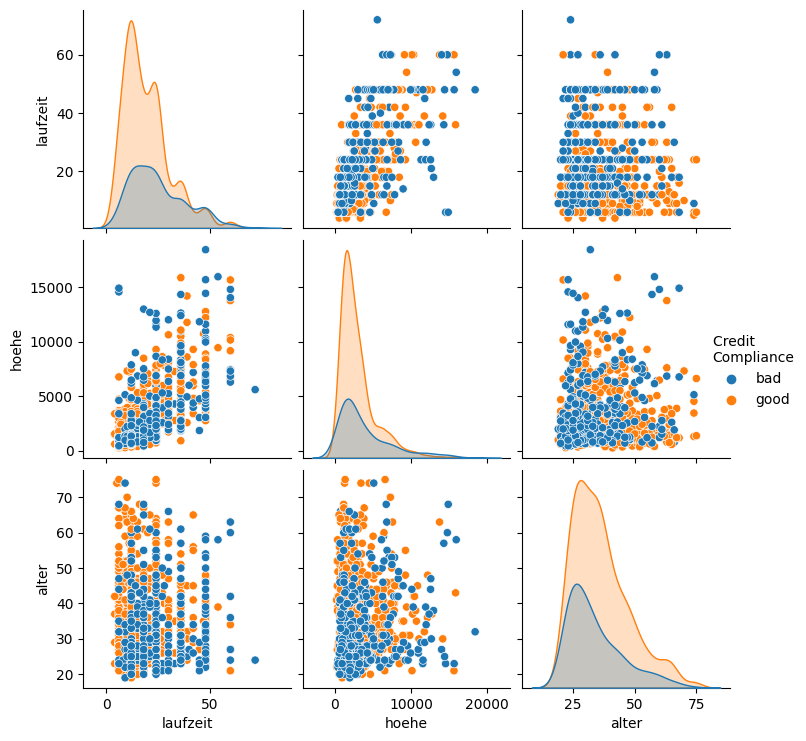

In [5]:
g = sns.pairplot(credit.loc[:, ["laufzeit", "hoehe", "alter", "kredit"]], hue="kredit")

# legend
g._legend.set_title("Credit \nCompliance")
# replace labels
for t, l in zip(g.legend.texts, ["bad", "good"]):
    t.set_text(l)

## SVM

### Select target and feature variables

In [6]:
y = credit['kredit']
X = credit.drop("kredit", axis=1)

### Split and Preprocess Data

Split data into a training and testing set. Apply OneHotEncoding to categorical variables; standardise all others.

In [7]:
# split data into testing and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# instanciate object that applies transformations to certain features
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# onehotencoding for categorical variables; standard scaler for the remainder
column_trans = ColumnTransformer(
    [('categorical', OneHotEncoder(), ['laufkont', 'moral', 'verw', 'sparkont', 'famges', 'buerge', 'weitkred', 'wohn'])],
    remainder=StandardScaler()
)

# apply transformation to training data
X_train = column_trans.fit_transform(X_train)
X_train = pd.DataFrame(data=X_train, columns = column_trans.get_feature_names_out())

# apply transformation to test data
X_test = column_trans.fit_transform(X_test)
X_test = pd.DataFrame(data=X_test, columns = column_trans.get_feature_names_out())

### Model Selection

Apply an exhaustive search over specified parameter values for the SVM

In [8]:
# define a parameter grid
params = {
    'C': [0.1, 1, 10, 100, 1000],
    #"gamma": [1, 0.1, 0.01, 0.001, 0.0001],
    'gamma': ['scale'],
    "kernel": ["rbf", "linear", "sigmoid"]
    }

# instantiate GSCV
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(
    estimator= svm.SVC(),
    cv = 5,
    n_jobs=5,
    verbose=1,
    param_grid=params)

# train model
clf.fit(X_train, y_train)

print(clf.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


### Fit Optimal Model

In [9]:
# initialise SVM
clf = svm.SVC(verbose=True, kernel="rbf", C=1)

# train model with training data
clf.fit(X_train, y_train)


[LibSVM]

SVC(C=1, verbose=True)

### Model Evaluation

Check the accuracy, precision

In [10]:
# predict target values with test data
predictions = clf.predict(X_test)

# accuracy
print(metrics.accuracy_score(y_test, predictions))
print(clf.score(X_test, y_test))

# precision 
print(metrics.precision_score(y_test, predictions))

# ROC (only really makes sense with computed probabilities)
#metrics.roc_auc_score(y_test, )

# classification report
print(metrics.classification_report(y_test, predictions, target_names = ['bad', 'good']))

0.76
0.76
0.7530120481927711
              precision    recall  f1-score   support

         bad       0.79      0.40      0.53        68
        good       0.75      0.95      0.84       132

    accuracy                           0.76       200
   macro avg       0.77      0.67      0.68       200
weighted avg       0.77      0.76      0.73       200



### Visualisation

Confusion Matrix

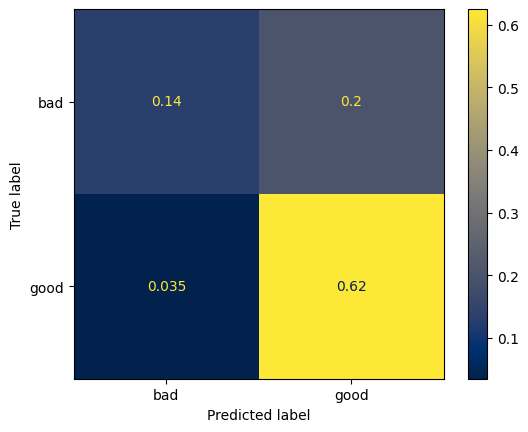

In [14]:
# Confusion Mat
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_estimator(
    clf,
    X_test,
    y_test,
    display_labels = ["bad", "good"],
    cmap = "cividis",
    normalize="all"
)

# distribution
#df_plot = pd.DataFrame(outcome = y_test)
#sns.displot(clf.decision_function(X_test), x = clf.score(X_test, y_test), kind = "kde", hue = "y_test")

# Roc